In [1]:
import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import curve_fit

from sklearn.metrics import r2_score 

plt.rcParams.update({'font.size': 12})

In [2]:
''' Load caliberation file '''

calibData = pd.read_excel("PWMCaliberation.ods", engine="odf")#pd.read_csv("PWMCaliberation.csv")  
CycleNum = 6 # Each trial of a caliberation repeats six times

cTime = calibData.loc[3::3,'PWM (%)'].values
pwmPercent = np.array(calibData.columns[1:], dtype=np.float64)

rowNum = cTime.shape[0]
colNum = pwmPercent.shape[0]

amplitude = calibData.iloc[3::3,1:].values * 1.915 
totalPower = calibData.iloc[4::3,1:].values * 1.915 
oneCyclePower = calibData.iloc[5::3,1:].values * 1.915 

# print(calibData.shape,cTime.shape,pwmPercent.shape,amplitude.shape,totalPower.shape,oneCyclePower.shape)

amp2 = np.array(totalPower * (1000/CycleNum) / cTime.reshape(-1,1), dtype=np.float64)
amp3 = np.array(oneCyclePower * 1000 / cTime.reshape(-1,1), dtype=np.float64)

Oscilloscope: Amplitude (inaccurate)
[ 383.  804. 1513. 1800. 2796. 4443. 4596. 5573. 5994. 6377. 6856.]
Oscilloscope: Total Area of six cycles
[2117. 2490. 3132. 3368. 4254. 5742. 5888. 6820. 7378. 7707. 8004.]
Oscilloscope: Area of one cycle (avg. of six cycles)
[1387. 1943. 2576. 2847. 3695. 5203. 5340. 6280. 6859. 7183. 7457.]
[  1.   2.   4.   5.   8.  15.  16.  32.  50.  64. 100.]


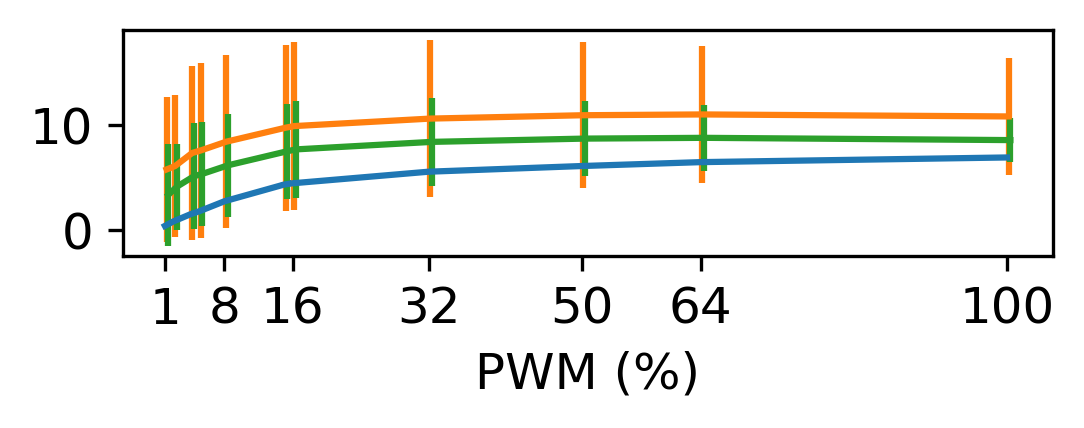

In [3]:
def plotErrorbar(Vmeasure, pwmPercent):
    amplitude = np.array(Vmeasure, dtype=np.float64)
    pwmPercent = np.array(pwmPercent, dtype=np.float64)

    ampMedian = np.median(amplitude, axis=0) 
    ampMean = np.mean(amplitude, axis=0) 
    ampSTD = np.std(amplitude, axis=0) 

    x = np.arange(colNum)
    
    plt.errorbar(pwmPercent, ampMean, ampSTD)

    print(f"{np.array2string(ampMedian*1000, precision=0)}")
  

fig1 = plt.figure(figsize = (4,1), dpi=300)
print("Oscilloscope: Amplitude (inaccurate)")
plotErrorbar(amplitude, pwmPercent)
print("Oscilloscope: Total Area of six cycles")
plotErrorbar(amp2, pwmPercent+0.2)
print("Oscilloscope: Area of one cycle (avg. of six cycles)")
plotErrorbar(amp3, pwmPercent+0.4)
plt.xticks(pwmPercent[[0,4,6,7,8,9,10]])
plt.xlabel('PWM (%)')

print(pwmPercent)

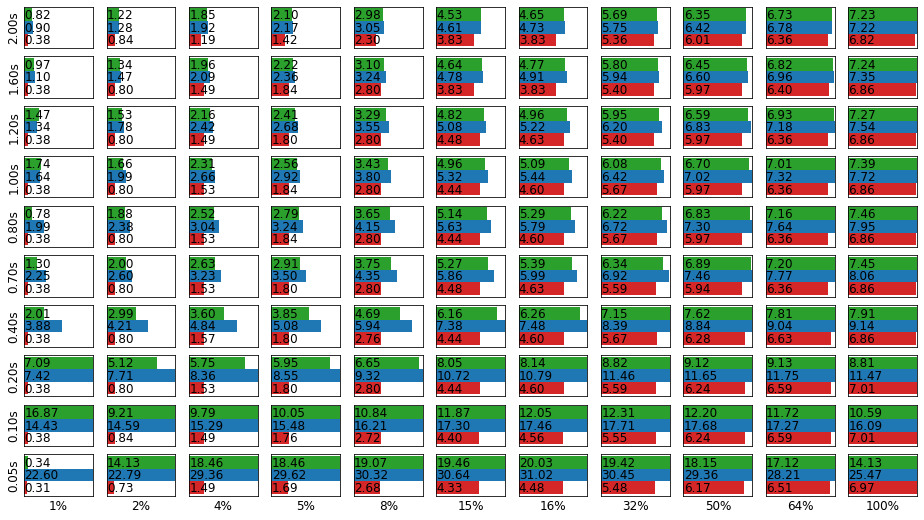

In [4]:
''' Exclude incorrect measurement: any cTime < 0.2, pwm < 0.04 '''
# amp2[-2:, :] = np.NaN
# amp2[:, :2] = np.NaN
# amp3[-2:, :] = np.NaN
# amp3[:, :2] = np.NaN

fig0, axes = plt.subplots(rowNum, colNum)
fig0.set_size_inches(16, 9)
textX = 0.02
y = np.arange(3)

for i in range(rowNum):
    for j in range(colNum):
        axes[i,j].barh(y+0.3, [amplitude[i,j], amp2[i,j], amp3[i,j]], height=1, color=['tab:red','tab:blue','tab:green']) 
        axes[i,j].text(textX, y[0], "%.2f" % amplitude[i,j])
        axes[i,j].text(textX, y[1], "%.2f" % amp2[i,j])
        axes[i,j].text(textX, y[2], "%.2f" % amp3[i,j])
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        axes[i,j].set_xlim([0, 7])
        
        if j == 0:
            axes[i,j].set_ylabel("%.2fs" % (cTime[i]/1000))
            
        if i == rowNum-1:
            axes[i,j].set_xlabel("%d%%" % (pwmPercent[j]))


1.2 sec charge Time: 
[1527. 2158. 3287. 4957. 5952. 6929. 7271.]
0.4  sec charge Time: 
[2987. 3605. 4692. 6262. 7153. 7813. 7909.]
0.2  sec charge Time: 
[5123. 5755. 6645. 8139. 8819. 9135. 8809.]


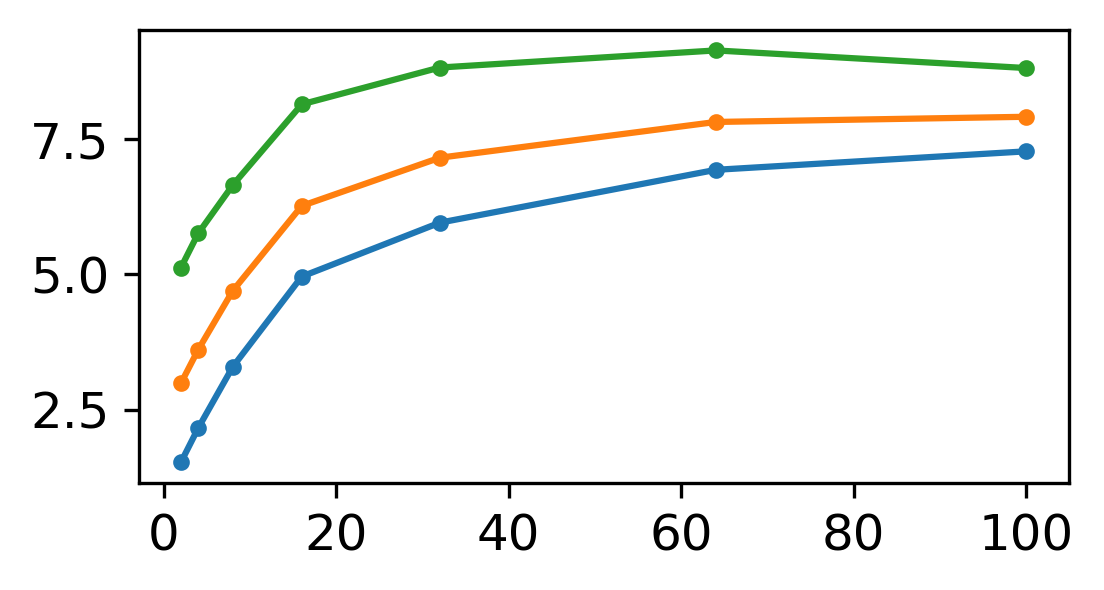

In [5]:
fig1 = plt.figure(figsize = (4,2), dpi=300)
# xData = np.tile(pwmPercent, rowNum)

usedInd = [1,2,4,6,7,9,10]

''' 1.2 sec charge Time '''
xData1 = pwmPercent[usedInd]
yData1 = amp3[2,usedInd].flatten() 

''' 0.4 sec charge Time '''
yData2 = amp3[6,usedInd].flatten() 

''' 0.2 sec charge Time '''
yData3 = amp3[7,usedInd].flatten() 

plt.plot(xData1, yData1, '.-')
plt.plot(xData1, yData2, '.-')
plt.plot(xData1, yData3, '.-')

print("1.2 sec charge Time: "); print(f"{np.array2string(yData1*1000, precision=0)}")
print("0.4  sec charge Time: "); print(f"{np.array2string(yData2*1000, precision=0)}")
print("0.2  sec charge Time: "); print(f"{np.array2string(yData3*1000, precision=0)}")

[  0.   2.   4.   8.  16.  32.  64. 100.] [0.        2.9874    3.6049875 4.69175   6.26205   7.152525  7.8132
 7.90895  ]
[7.59587267 6.96213931 0.12344511]
Fitting R2 = 0.969591 (Y(0) = 0.633733, Y(100) = 7.595842)


C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


' The relation ship between PWM and Voltage is V = 7.60-6.96exp(-0.12PWM))'

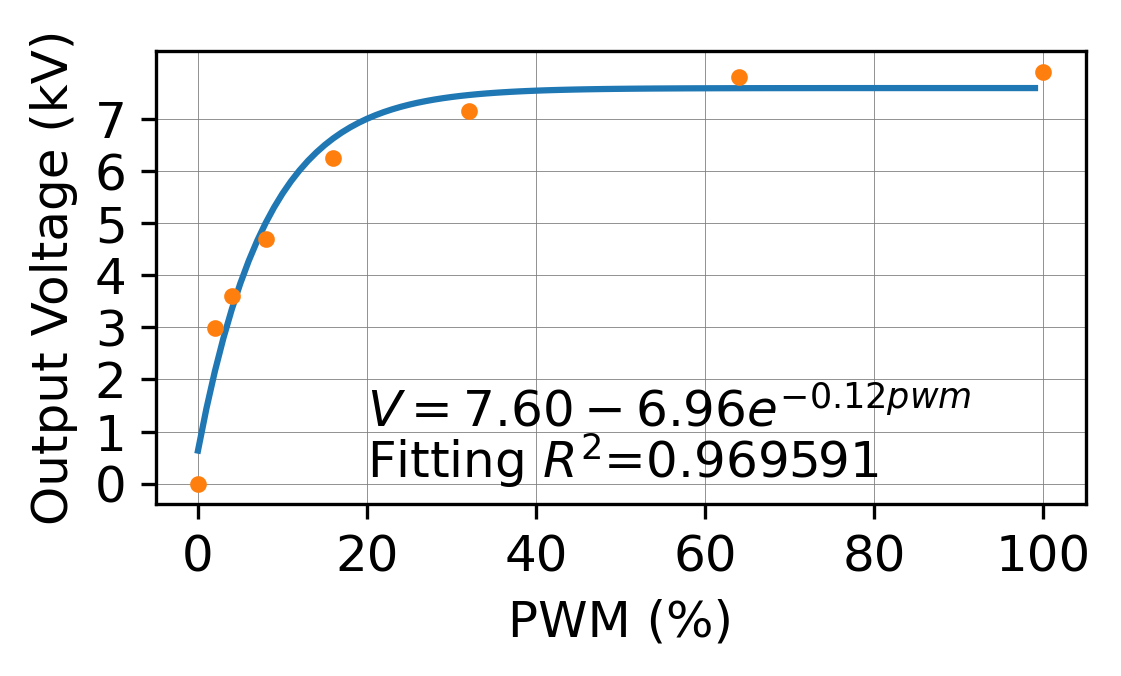

In [6]:
''' Modelling the relation between PWM and voltage output of 0.4 sec charge time'''
def objective(x, a, b, c):
    return a - b * np.exp(-c*x)

# xDataFit = pwmPercent[usedInd]
# yDataFit = amp3[6,usedInd].flatten() 
xDataFit = pwmPercent[usedInd]
yDataFit = amp3[6,usedInd].flatten() 

xDataFit = np.insert(xDataFit, 0, 0)
yDataFit = np.insert(yDataFit, 0, 0)

print(xDataFit, yDataFit)

popt, _ = curve_fit(objective, xDataFit, yDataFit, method='lm')
print(popt)

''' Evaluate fitting performance '''
yPred = objective(xDataFit, *popt)
R_sq = r2_score(yDataFit, yPred) 
print("Fitting R2 = %f (Y(0) = %f, Y(100) = %f)" % (R_sq, objective(0, *popt), objective(100, *popt)))

''' Plot the fitting curve '''
x = np.arange(100)
y = objective(x, *popt)
fig1 = plt.figure(figsize = (4,2), dpi=300)
plt.plot(x, y)
plt.plot(xDataFit, yDataFit, '.')
plt.xlabel('PWM (%)');
plt.ylabel('Output Voltage (kV)')
plt.yticks(range(8))
ax = plt.gca()
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linewidth=0.2)
ax.yaxis.grid(color='gray', linewidth=0.2)

plt.text(20, 1.1, r"$V=%.2f-%.2fe^{-%.2fpwm}$" % (popt[0], popt[1], popt[2]))
plt.text(20, 0.1, r"Fitting $R^2$=%.6f" % R_sq)

# fig1.savefig("PWM2Volt.pdf", bbox_inches='tight', dpi=300)

''' The relation ship between PWM and Voltage is V = 7.60-6.96exp(-0.12PWM))'''

In [ ]:
''' The data used for this model may not be correct: Use Area instead of Amplitude measurement '''

def objective(x, c):
    return 6.9 - 6.9 * np.exp(-c*x)

xData = np.tile(pwmPercent, rowNum)
yData = amplitude.flatten() 

popt, _ = curve_fit(objective, xData, yData, method='lm')
print(popt)
popt[0] = 0.06

''' Evaluate fitting performance '''
yPred = objective(xData, *popt)
R_sq = r2_score(yData, yPred) 
print("Fitting R2 = %f (Y(0) = %f, Y(100) = %f)" % (R_sq, objective(0, *popt), objective(100, *popt)))

''' Plot the fitting curve '''
x = np.arange(100)
y = objective(x, *popt)
fig1 = plt.figure(figsize = (4,2), dpi=300)
plt.plot(x, y)
plt.plot(xData, yData, '.')
plt.xlabel('PWM (%)');
plt.ylabel('Output Voltage (kV)')
plt.yticks(range(8))
ax = plt.gca()
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linewidth=0.2)
ax.yaxis.grid(color='gray', linewidth=0.2)

plt.text(40, 1.1, r"$V=6.9-6.9e^{-0.06pwm}$")
plt.text(40, 0.1, r"Fitting $R^2$=%.6f" % R_sq)

# fig1.savefig("PWM2Volt.pdf", bbox_inches='tight', dpi=300)
# ''' The relation ship between PWM and Voltage is V = 6.9-6.9exp(-0.06PWM))'''